# Import Libraries

In [1]:
# For CPU Operations
import time
import logging
import subprocess
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

# For GPU array computation
import cupy as cp

# For GPU dataframe operation
import cudf

# Default DASK Libraries and set use GPU's
import dask
import dask_cudf
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

# Set for Multi GPU use
from dask_cuda        import LocalCUDACluster
from dask.distributed import Client, wait, progress

# Dask Machine Learning Libraries
import dask_ml
from dask_ml.metrics         import mean_squared_error 
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers        import ParallelPostFit

# Import cuml RandomForest
from cuml.ensemble import RandomForestClassifier as RF
from cuml.dask.ensemble import RandomForestClassifier as RF_Dask

# For Visualization
import matplotlib
import matplotlib.pyplot as plt
import graphviz


# Set Multi-GPU Client

In [2]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR, silence_logs=logging.ERROR)
client = Client(cluster)

# Check Client

In [3]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://192.168.0.69:8787/status,
Dashboard: http://192.168.0.69:8787/status,Workers: 2
Total threads: 2,Total memory: 31.27 GiB
Status: running,Using processes: True
Comm: tcp://192.168.0.69:36293,Workers: 2
Dashboard: http://192.168.0.69:8787/status,Total threads: 2
Started: Just now,Total memory: 31.27 GiB
Comm: tcp://192.168.0.69:41005,Total threads: 1
Dashboard: http://192.168.0.69:37863/status,Memory: 15.63 GiB
Nanny: tcp://192.168.0.69:42051,


# Load and Preprocessing Bank Account Fraud Dataset

In [4]:
usecols = ["fraud_bool",'income', 'name_email_similarity', 'current_address_months_count',
           "bank_months_count", "prev_address_months_count", "velocity_4w",
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'employment_status', 'credit_risk_score', 'email_is_free',
       'housing_status', 'phone_home_valid', 'phone_mobile_valid',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month']
dask_df = dd.read_csv("../data/bank/Variant*.csv", na_values= ['-1'], usecols=usecols)
dask_df = dask_df.persist()

In [5]:
!ls -lh ../data/bank/

합계 1.3G
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 204M 11월 29  2023  Base.csv
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 204M 11월 29  2023 'Variant I.csv'
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 204M 11월 29  2023 'Variant II.csv'
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 241M 11월 29  2023 'Variant III.csv'
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 204M 11월 29  2023 'Variant IV.csv'
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 241M 11월 29  2023 'Variant V.csv'


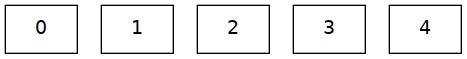

In [6]:
dask_df.visualize()

In [7]:
dask_df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
def LabelEncoder(dd:dask.dataframe)->dask.dataframe:
    columns = dd.columns
    for c in columns:
        categories = dd[c].compute().unique()
        cat_dict   = {c : i for i, c in enumerate(categories.values_host)}
        dd[c] = dd[c].map(cat_dict)
    return dd

def standard_scaler(ddf:dd.DataFrame) -> dd.DataFrame:
    columns = ddf.columns
    for c in columns:
        mean = ddf[c].mean()
        std  = ddf[c].std()
        ddf[c]   = (ddf[c] - mean) / std
    return ddf

In [9]:
label_col = list(dask_df.select_dtypes(include=["object", "category"]).columns)
scale_col = list(dask_df.select_dtypes(include=["number"]).columns[1:])
dask_df[label_col] = LabelEncoder(dask_df[label_col])
dask_df[scale_col] = standard_scaler(dask_df[scale_col])
dask_df = dask_df.drop(["bank_months_count", "prev_address_months_count", "velocity_4w"], axis=1)
dask_df = dask_df.dropna().astype(cp.float32)

train, test = dask_df.random_split([0.8, 0.2])
X_train, y_train = train.drop(["fraud_bool"], axis=1), train["fraud_bool"].astype(cp.int32)
X_test,  y_test  = test.drop(["fraud_bool"], axis=1), test["fraud_bool"].astype(cp.int32)

# Set RandomForest

In [10]:
%%time
model = RF(n_estimators=100, max_depth=8)
model.fit(X_train, y_train)

CPU times: user 13.8 s, sys: 14.9 s, total: 28.7 s
Wall time: 31.4 s


RandomForestClassifier()

In [11]:
%%time
model = RF_Dask(n_estimators=100, max_depth=8, client=client)
model.fit(X_train, y_train)

/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


CPU times: user 2.04 s, sys: 175 ms, total: 2.22 s
Wall time: 14.2 s


# Test Random Forest

In [12]:
pred = model.predict(X_test)

In [13]:
pred = cp.asnumpy(pred.compute().to_cupy())
gt   = cp.asnumpy(y_test.compute().to_cupy().flatten())
accuracy = np.where(pred==gt, 1, 0).sum() / len(gt)
print(f"Accuracy : {accuracy:.2f}%")

Accuracy : 0.99%
